<h1 style="text-align: center;"><strong>Meeting Report</strong></h1>


### IMPORT

In [69]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from _data_manager import DataManager
from _trade import Trade
from _long_short_trade import TradeLongShort
from _backtesting import Backtest
from _strategy_linear_regression import StrategyLinearRegression, StrategyLinearRegressionMultiAgent
from _strategy_cross_yield import StrategyCrossYield
from _trade_filter import TradeFilter


In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Option d'affichage


In [71]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')



# DATA ANALYSIS

To work efficiently with data, I created the `DataManager` class. This class streamlines the necessary transformations for analyzing bond yields. It loads the data, organizes it by date, country, and maturity, and calculates key statistics such as ranks, yield spreads, averages, and rolling standard deviations, thereby enabling a thorough and comparative analysis of bond performance.

In [72]:
file_path = 'EGB_historical_yield.csv'
data_manager = DataManager(file_path)


In [73]:
data_manager.data.shape

(2110, 21)

In [74]:
data_manager.data.head()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,-16.4,53.9,131.2,-2.1,83.8,189.7,-8,77.7,160.4,-10.4,66.1,143.6,-10.4,66.1,143.6,65.4,175.0,291.2,56.1,156.4,264.9
2016-01-18,-16.6,53.6,131.2,-3.3,83.5,190.0,-8,77.4,160.7,-10.6,66.0,143.9,-10.6,66.0,143.9,64.0,174.0,291.5,56.6,156.4,266.9
2016-01-19,-16.7,54.8,132.2,-4.1,84.0,189.9,-8,78.3,161.8,-11.3,66.1,145.1,-11.3,66.1,145.1,60.5,170.1,288.2,55.3,155.7,265.2
2016-01-20,-19.8,48.1,122.5,-6.0,96.3,184.2,-11,73.2,153.1,-13.8,60.9,135.9,-13.8,60.9,135.9,65.7,178.2,296.7,62.2,164.9,275.9
2016-01-21,-24.0,44.9,121.4,-9.8,91.5,180.5,-16,69.6,153.0,-18.2,57.0,134.8,-18.2,57.0,134.8,60.2,171.9,291.5,54.4,156.1,269.5


In [75]:
data_manager.data.dtypes

Germany_5y         float64
Germany_10y        float64
Germany_30y        float64
Belgium_5y         float64
Belgium_10y        float64
Belgium_30y        float64
Austria_5y           int64
Austria_10y        float64
Austria_30y        float64
Netherlands_5y     float64
Netherlands_10y    float64
Netherlands_30y    float64
France_5y          float64
France_10y         float64
France_30y         float64
Spain_5y           float64
Spain_10y          float64
Spain_30y          float64
Italy_5y           float64
Italy_10y          float64
Italy_30y          float64
dtype: object

For the Austria 5-year rates, we only have `int64` data types, which likely indicates a lack of precision in this measurement compared to others. Given 2110 rows, the probability of having only integer numbers is virtually zero.

In [76]:
data_manager.data.isnull().sum().sort_values().head(3)

Germany_5y    0
Italy_5y      0
Spain_30y     0
dtype: int64

There are no missing data, which is good news.

In [77]:
data_manager.data.describe()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
count,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,11.990521,47.930995,94.990332,31.534313,88.705403,165.658104,29.082938,79.211185,135.861327,18.575592,66.287488,104.963886,18.575592,66.287488,104.963886,69.074645,145.899763,236.917393,135.596066,219.323081,301.104076
std,110.244206,97.853356,84.547229,116.515992,109.453098,96.159139,119.676026,112.184716,93.752196,116.077422,104.988257,90.751273,116.077422,104.988257,90.751273,116.066133,106.837146,97.354064,127.540894,120.103048,96.317931
min,-99.100000,-85.800000,-49.300000,-72.400000,-43.600000,26.400000,-76.000000,-48.500000,-6.600000,-86.800000,-65.200000,-38.100000,-86.800000,-65.200000,-38.100000,-45.700000,-1.900000,79.600000,-12.600000,45.500000,138.200000
25%,-58.500000,-26.275000,24.000000,-43.275000,7.200000,84.825000,-44.000000,-2.575000,56.200000,-52.800000,-12.275000,28.600000,-52.800000,-12.275000,28.600000,-13.400000,46.650000,136.625000,36.425000,121.650000,220.900000
50%,-35.400000,25.100000,90.850000,-19.650000,64.700000,160.600000,-25.000000,49.500000,132.500000,-32.200000,41.450000,99.350000,-32.200000,41.450000,99.350000,29.050000,140.150000,251.050000,78.050000,196.100000,302.650000
75%,4.050000,61.125000,127.550000,22.300000,95.750000,185.075000,14.000000,80.775000,157.800000,-2.550000,73.675000,131.000000,-2.550000,73.675000,131.000000,61.675000,169.075000,288.275000,212.850000,298.525000,361.925000
max,289.100000,296.600000,320.600000,324.400000,362.800000,418.800000,332.000000,358.400000,379.100000,313.000000,331.100000,344.600000,313.000000,331.100000,344.600000,368.300000,406.600000,469.100000,435.100000,497.900000,544.200000


In [78]:
data_manager.data.std(axis=0).sort_values()

Germany_30y         84.547229
France_30y          90.751273
Netherlands_30y     90.751273
Austria_30y         93.752196
Belgium_30y         96.159139
Italy_30y           96.317931
Spain_30y           97.354064
Germany_10y         97.853356
France_10y         104.988257
Netherlands_10y    104.988257
Spain_10y          106.837146
Belgium_10y        109.453098
Germany_5y         110.244206
Austria_10y        112.184716
Spain_5y           116.066133
France_5y          116.077422
Netherlands_5y     116.077422
Belgium_5y         116.515992
Austria_5y         119.676026
Italy_10y          120.103048
Italy_5y           127.540894
dtype: float64

Long-term bonds are generally less volatile than short-term ones, but there are some exceptions, such as the 5-year German bond (which is in the 10-year group), or Italy 10-year, which is the second most volatile bond. This indicates higher uncertainty for Italy and lower uncertainty for Germany, which is more stable. Interestingly, the order by maturity is roughly but not always consistent (such as with Spain for the 5-year rate, which is second vs. last for the 30-year rate).

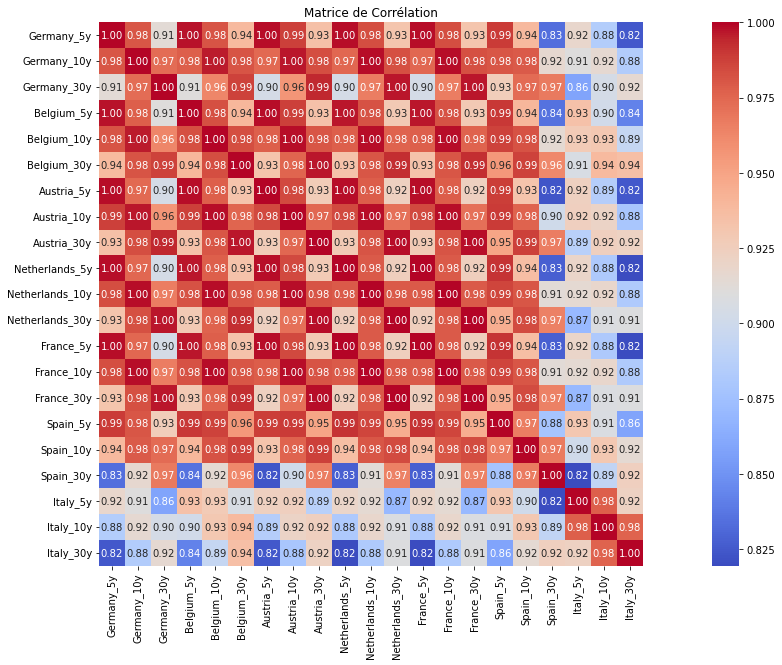

In [79]:
corr = data_manager.data.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

The set is highly correlated, with Italy appearing to be significantly less correlated than other nations with each other. It is observed that in many instances, countries with equal maturity have almost perfect correlations.

# Dashboard

The best way to understand data is to have the ability to view and navigate through it easily, which is why I decided to create a complete interactive dashboard to thoroughly comprehend it. Indeed, the fixed income field is not very familiar to me, and being able to understand the data I work with is very important. To view the data, launch the dashboard, which offers numerous data visualizations.

Here is the url of the dashboard once launched : http://127.0.0.1:8050/

# Backtesting Framework

To evaluate strategies, I needed a backtester. Given that the P&L of yields follows a specific logic, I had to code a backtester from scratch. However, since the P&L logic is somewhat opposite to that of equity, I could have simply inverted the yields and used a standard backtester to avoid reinventing the wheel. Nonetheless, I decided to create a framework from scratch to gain flexibility and avoid being slowed down by learning to use a backtesting library, which is not the objective of this exercise.

I have two classes that facilitate the execution of trades:
- `Trade`: This class models a financial operation, enabling the calculation and tracking of daily profit and loss (P&L) for an asset over a given period, considering options such as stop loss.
- `TradeLongShort`: This class implements a trading strategy of being long on one asset and short on another when two indices cross, calculating and tracking the daily P&L for the specified period, with the option to include a stop loss.

Then, for backtesting, I have a class that accounts for a list of Trades:
- The `Backtest` class is designed to execute a backtest of trading strategies, consolidating the profit and loss (P&L) data from multiple trades provided in a list and visualizing them with a chart. It includes preparing the P&L data for each trade, calculating the total P&L over the backtest period, and the ability to add methods for evaluating backtest performance, such as the Sharpe ratio, total return, and the percentage of winning trades.

# Strategy 1 : cross yield

We observe a mean-reverting behavior; notably, when inspecting visually, it becomes apparent that whenever two yields intersect, they tend to intersect once more at a later point. This observation motivates the exploration of a strategy that entails initiating a long-short position upon the yields' intersection and subsequently exiting the position when they intersect again.

The question at hand was how to generate these signals. Initially, I embarked on a very complex approach, but then I develop a simpler solution. This simpler solution involves taking the yield spread of each pair of yields. Thus, when the yield changes from negative to positive (or vice versa), it indicates that the yields have crossed.

The `StrategyCrossYield` class detects sign changes in yield spreads to generate trading signals, maintaining positions based on yield intersections and incorporating stop-loss strategies. 

The `TradeCreationLongShort` class processes these signals to create and manage a list of long-short trades, considering holding periods and stop-loss parameters.

### Results

In [88]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [5,10,20,40]
stop_loss = None

In [89]:
for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:

    cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop_loss)
    liste_trades = cross_strategy.execution_of_strategy()
    
    title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days"
    backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
    backtest_cross_strategy.gather_all_trades()
    backtest_cross_strategy.plot_p_and_l(title)


We notice that this strategy manages to produce results over time. It is observed that the more time is allowed for positions to reach their potential, the better this strategy performs because there is a greater chance that order will be restored. Therefore, if one must stick to a strategy, it would be the 40-day (2 months) one. However, it is observed that this strategy experiences significant drawdowns, which are of very short duration before being erased.

In [95]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [20,40]
stop_loss = [-10,-20,-50,-100]

In [96]:
for stop in stop_loss:
    for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:

        cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop)
        liste_trades = cross_strategy.execution_of_strategy()
        
        title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days"
        backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
        backtest_cross_strategy.gather_all_trades()
        backtest_cross_strategy.plot_p_and_l(title)

Amélioration

Conclusion

# Strategy 2

In [ ]:
#

(21, 2110)

# Pour aller plus loin

### Données économiques que l'on pourrait rajouter pour aller plus loin :

- Inflation
- Chômage
- PIB (Produit Intérieur Brut)
- Indice des prix à la consommation
- Indice des prix à la production (IPP)
- Balance commerciale
- Indices boursiers
- Indicateurs de sentiment de marché
